In [1]:
# Append path for src modules
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
#import pandas as pd
#import numpy as np
from rtmodel import seaicert_mp
from plotting import plot_results, plot_thickness_profile

from mosaic_thickness import load_data, MAGNAPROBE_PATH

In [2]:
df = load_data(MAGNAPROBE_PATH / '20200627-PS122-4_44-267' / 'magna+gem2-transect-20200627_PS122-4_44-267_transect.csv')
df.head()

,lon,lat,local_x,local_y,snow_depth_m,melt_pond_depth_m,surface_type,ice_thickness_18khz_ip_m,ice_thickness_5khz_ip_m,ice_thickness_93khz_ip_m,ice_thickness_mean_m,transect_distance_m
Date/Time,,,,,,,,,,,,
2020-06-27 11:22:46,9.89478,81.95278,-153.212507,-73.419080,0.05502,0.0,1,3.521437,4.030694,4.144066,3.898732,0.000000
2020-06-27 11:22:55,9.89510,81.95277,-157.810002,-70.192152,0.05277,0.0,1,3.667773,4.484344,4.169916,4.107344,5.616941
2020-06-27 11:23:09,9.89550,81.95272,-161.934210,-66.335585,0.09930,0.0,1,3.426157,3.726871,3.917157,3.690062,11.263374
2020-06-27 11:23:17,9.89592,81.95270,-164.498767,-58.848335,0.09980,0.0,1,2.872571,2.935657,3.384771,3.064333,19.177656
2020-06-27 11:23:24,9.89624,81.95268,-168.702058,-53.028117,0.06230,0.0,1,3.049500,3.307100,3.552843,3.303148,26.356972


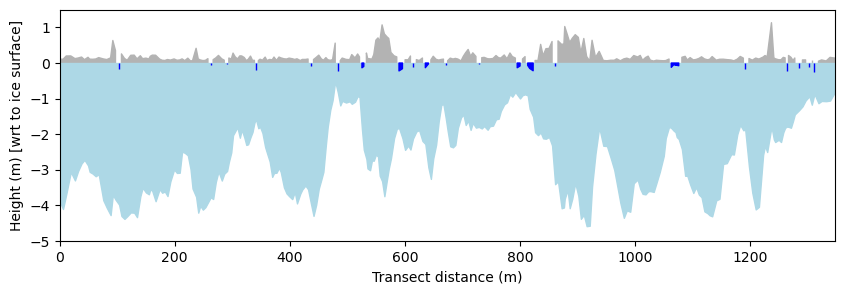

In [3]:
fig, ax = plt.subplots(figsize=(10,3))
plot_thickness_profile(df, ax=ax)  # Add legend and axis title with units

In [4]:
rt_df = seaicert_mp(df)
rt_df.head()

,datetime,latitude,snow_depth_m,melt_pond_depth_m,ice_thickness_mean_m,sw_absorbed_by_ocean,surface_albedo,surface_downwelling_radiative_flux,transect_distance_m
transect_distance_m,,,,,,,,,
0.000000,2020-06-27 11:22:46,81.95278,0.05502,0.0,3.898732,0.166011,0.848785,361.224457,0.000000
5.616941,2020-06-27 11:22:55,81.95277,0.05277,0.0,4.107344,0.134528,0.847551,360.638550,5.616941
11.263374,2020-06-27 11:23:09,81.95272,0.09930,0.0,3.690062,0.125738,0.862638,367.938049,11.263374
19.177656,2020-06-27 11:23:17,81.95270,0.09980,0.0,3.064333,0.256464,0.862709,367.973846,19.177656
26.356972,2020-06-27 11:23:24,81.95268,0.06230,0.0,3.303148,0.299024,0.852242,362.877380,26.356972


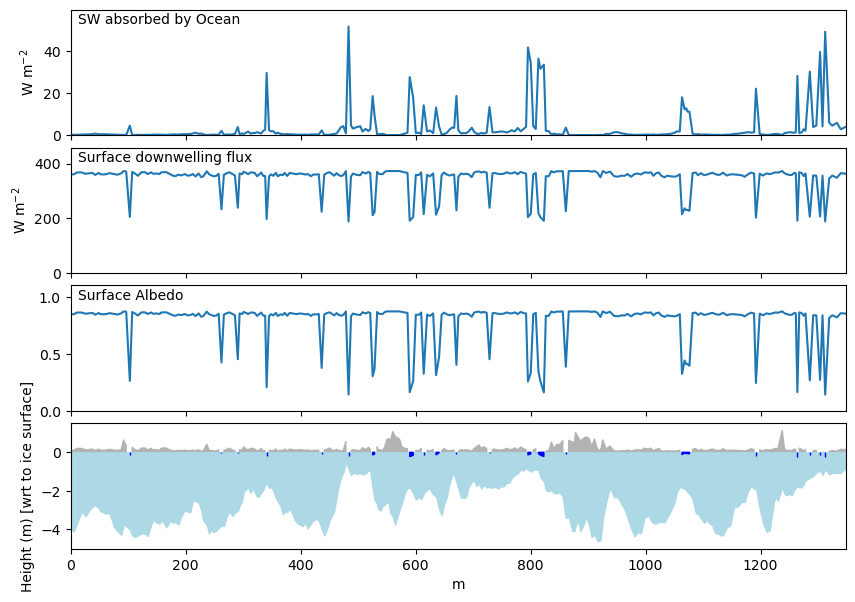

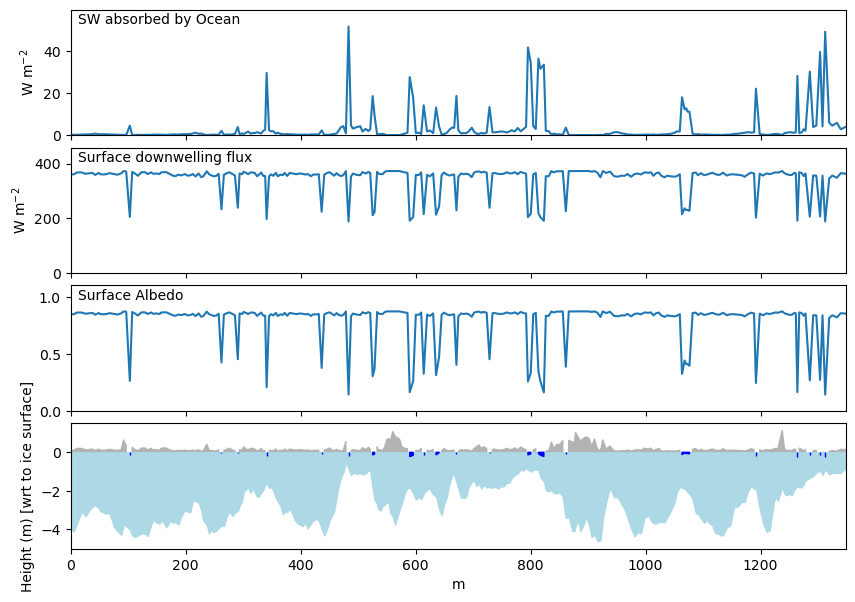

In [5]:
plot_results(rt_df)